# Grid Cell Phase Coding 

Phases are in radians, coordinates are in [m] and time base is [ms].
The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value and so on. So those files should have the same number of rows and if you merge them as columns each row should correspond with the same spike event.
So here is an important detail to pay attention to. __Because the spike times in the file are not in an ascending order but in the order of cells combined (like cell1 t1, cell1 t2, cell1 t3,..., cell2 t1, cell2 t2, cell2 t3,...)  if you sort them you will need to reindex the XYspkT and Phase data too.__
Or you just leave them as they are. Then they remain aligned.
 
The ultimate task is to predict the place where the avatar goes next based on the phase of the next spike. We have all the info we need. We know where the avatar is in space (X,Y), we know the phase of the next spike and we know the average map of all phases. We just need to find where the next spike would best fit on that map of opportunities based on average phases. Because average phases tessellate like grids, therefore for a given spike phase there are multiple spots in the field where that spike can ideally land. Of course the real landing spot is  one that is nearby, since the avatar does not jump. So we need to look the map of average phases at the local neighborhood and find the best match between the actual phase and the average phase map. The vector between the avatar's actual position and the predicted position (i.e the position where the phase of next spike would best match) defines a vector of moving direction. These are the small arrows in my plot.

An example:  
Let say the spike that just happened at t0 was generated at 30 degree (0.5236 rad) of the ongoing gamma cycle. We know the avatar's spatial position (X,Y). We also know that next spike t1 will be generated at 45 degree but we don't know at what spatial position. So we are considering the next 6 spikes (where 6 is an arbitrary number)  or a 5 x 5 m area around the spike (where 5 is an arbitrary metric) and try to find a tile with the average phase that best fit to the phase of next spike. That tile would be our best guess for the next position of the avatar.

Of course, for a cross-validation purpose, we will need to divide the data into a training set and decoding set (or predicting set). That will be the second step. But for start, let's just try to decode the phase using the entire 5 min data.


### TODO: add firing map, only look at low variance phase map, different environments, smaller matrix, consider rounding of XYspkT (up to preserve + amplify small movements?), generate new phasemap

### pay critical attention to whether coordinates in numpy [-y,x] or Cartesian [x,y]

In [1109]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'

In [1110]:
dir = 'datasets/5/'

#Option to all coordinates to compensate for coarse grain of meanphasemap
round_XY = False

#Spatial or temporal analysis
spatial = True

## XYspkT

XYspkT contains the X,Y coordinates of spikes. Spikes from all 30 neurons are combined in a single spike train. The X and Y columns represent the avatar's X-Y coordinate in [m] relative to the environment at the moment of the spike. 

XYspkT is float values, can be converted to integer with np.round(scaled_XY) as the coarse spatial analysis from the adjacency matrix only results in integer movement predictions

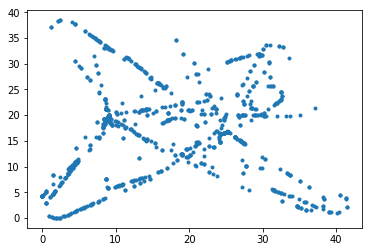

In [1111]:
XYspkT = np.loadtxt(dir+'XYspkT.csv',delimiter=',')

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

if round_XY == True:
    scaled_XY = np.round(scaled_XY)

plt.plot(scaled_XY[:,0],scaled_XY[:,1],'.')

## spkT

spkT contains the times of the spikes in ms

In [1112]:
spkT = np.loadtxt(dir+'spkT.csv',delimiter=',')
print(spkT)
spkT.shape

[  2450.  16649.  17748.  17981.  18231.  43384.  43568.  43601.  43834.
  56666.  56779.  57696.  58079.  58812.  62098.  62331.  63431.  76117.
  76200.  96744.  97244.  97311. 116060. 116200. 116220. 116530. 117330.
 117580. 118300. 118760. 130320. 130470. 130600. 131570. 162690. 163720.
 164550. 164910. 177150. 177240. 177320. 177850. 178040. 192250. 192970.
 214000. 219260. 219340. 221330. 233960. 241310. 243080. 244740. 251810.
 278030.  13069.  16982.  18198.  18614.  18714.  59362.  61698.  62848.
  63215.  75267.  76033.  97111.  97194. 118390. 130120. 130370. 131250.
 131430. 131630. 162370. 162440. 162550. 176270. 176800. 176870. 177000.
 178070. 192540. 193140. 220410. 242790. 243190. 243240. 243390. 243560.
 250500. 251230. 251860. 252210.   1901.   2200.  17415.  20580.  57229.
  57729.  57996.  62615.  63165.  75533.  76367.  94730.  96694.  96711.
  97211.  97428. 108640. 114750. 130100. 130270. 131620. 134720. 162650.
 162830. 193120. 198020. 201740. 219580. 219760. 24

(902,)

## Phase

Phase is the corresponding (gamma) phase of the spikes - what phase the gamma oscillation was at them moment of spike

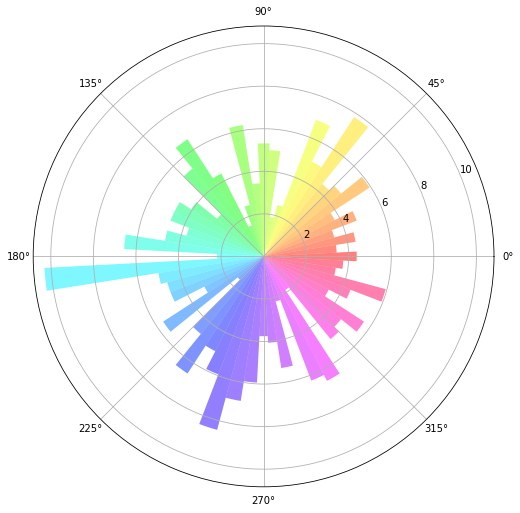

In [1113]:
phase = np.loadtxt(dir+'Phase.csv',delimiter=',')
scaled_phase = phase-3.14

phase_degrees = np.degrees(phase)
sorted_phase = np.sort(phase_degrees)


#Radial histogram of phase distribution
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = np.radians(np.arange(0,366,6))

inds = [np.where(sorted_phase<i)[0][-1] for i in np.arange(6,366,6)] #vectorize operation?
b = np.split(sorted_phase,inds)
radii = np.array([i.size/3.2 for i in b])

width = np.radians(360/60)
bars = ax.bar(theta, radii, width=width, bottom=0.0)
for theta, bar in zip(theta, bars):
    bar.set_facecolor(plt.cm.hsv(theta/6.28))
    bar.set_alpha(0.5)

plt.show()

## MeanPhaseMap

MeanPhaseMap the map of gamma phases. This is a 40x43 matrix that represents the 80x86 m land of the desert, the area covered by the avatar's navigation. The lot of NaN data correspond with areas never visited. A given value at the n-th row and m-th column represents the average phase of spikes (all spikes) within that area during the entire 5 min navigation. 

TODO:

-(time based meanphasemap of first half, traj from second)

-average internode distance

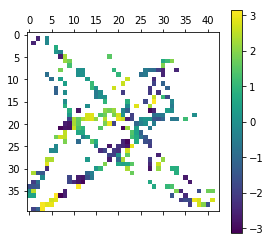

In [1114]:
raw = np.loadtxt(dir+'MeanPhaseMap.csv',delimiter=',')

#Flipping to align + stripping erraneous values
MeanPhaseMap = np.flip(raw,axis=0)
MeanPhaseMap[0]='NaN'
MeanPhaseMap[:,-1]='NaN'
arena_size = MeanPhaseMap.shape

plt.matshow(MeanPhaseMap)

#To-do: reflect radians in bar
plt.colorbar()

## Binned Phase Map

In [1115]:
def remove_singles(array):
    has_neighbor = np.zeros(array.shape, bool)
    has_neighbor[:, 1:] = np.logical_or(has_neighbor[:, 1:], array[:, :-1] > 0)  # left
    has_neighbor[:, :-1] = np.logical_or(has_neighbor[:, :-1], array[:, 1:] > 0)  # right
    has_neighbor[1:, :] = np.logical_or(has_neighbor[1:, :], array[:-1, :] > 0)  # above
    has_neighbor[:-1, :] = np.logical_or(has_neighbor[:-1, :], array[1:, :] > 0)  # below

    array[np.logical_not(has_neighbor)] = 0
    return array

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


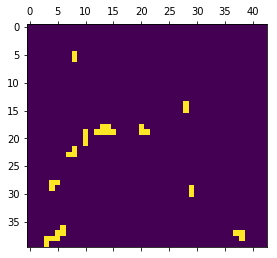

In [1116]:
MPM3 = (MeanPhaseMap>2)*1
filtered_MPM3 = remove_singles(MPM3)
plt.matshow(filtered_MPM3)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


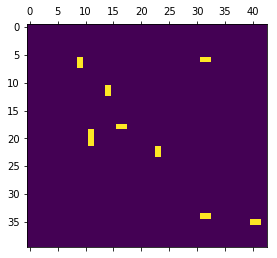

In [1117]:
MPM2 = ((MeanPhaseMap>1) & (MeanPhaseMap<2))*1
filtered_MPM2 = remove_singles(MPM2)
plt.matshow(filtered_MPM2)

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


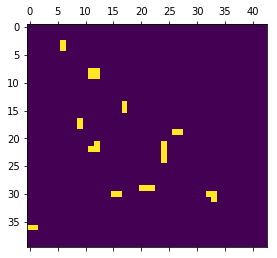

In [1118]:
MPM1 = ((MeanPhaseMap>0) & (MeanPhaseMap<1))*1
filtered_MPM1 = remove_singles(MPM1)
plt.matshow(filtered_MPM1)

## xyPos
xyPos is the trajectory traveled by the avatar. Each row is an X-Y data pair in [m] sampled in every ms. It is the biggest file because of the density of points. You can down-sample it to make it more manageable.

In [ ]:
xyPos = np.loadtxt(dir+'xyPos.csv',delimiter=',')[::25]
xyPos[:,1]-= xyPos[:,1].min()
xyPos[:,0]-= xyPos[:,0].min()
print(xyPos)

#Trajectory overlaid with XYspkT
plt.plot(xyPos[:,0],xyPos[:,1], color='b')
plt.plot(XYspkT[:,0],XYspkT[:,1], '.', color='r', markersize=6)

## MeanPhaseMap DataFrame


In [ ]:
phase_df = pd.DataFrame(data=MeanPhaseMap, columns=np.arange(arena_size[1]))
phase_df

In [ ]:
#A padded phase map for use in edge-cases for extracting the 5x5 adjacency matrix below
padded_phase_map = np.pad(MeanPhaseMap,pad_width=2,mode='constant',constant_values=np.nan)
padded_phase_df = pd.DataFrame(data=padded_phase_map, columns=np.arange(arena_size[1]+4))
padded_phase_df



### Adjacent Matrix Function

Returns a 5x5 array to analyze a region of space adjacent to a target location within the MeanPhaseMap, then finds
the x and y difference from the center to cell to the cell with the cloest matching value (of phase).

example return array:

       [ 3.0844,     nan, -1.5684,     nan,     nan],

       [ 3.0844,     nan,     nan, -1.6837, -1.5763],
       
       [    nan,     nan,     nan,     nan, -1.5088],
       
       [-2.8458,     nan,     nan,     nan, -2.5082],
       
       [-2.8458,     nan,     nan,     nan,     nan]

In [ ]:
def adjacent_matrix(cell):
    cell = list(map(round, cell))
    c_x = int(cell[0])
    c_y = int(cell[1])
    y_size = arena_size[0]-1
    a = padded_phase_df.iloc[y_size-c_y+2:y_size-c_y+7,c_x-2:c_x+3]
    
    return a

def adjacent_spikes(spikes, phase):
    
    #get location of spike with most similar phase
    y_size = arena_size[0]-1
    phases = np.asarray([phase_df.iloc[y_size-int(i[1]),int(i[0])] for i in spikes])
    
    try:
        nearest = np.nanargmin(np.abs(phases-phase))
    except:
        nearest = 0
    
    try:
        return [spikes[nearest,0]-spikes[0,0],spikes[nearest,1]-spikes[0,1]]
    except:
        return [0.0,0.0]

def nearest_phase(array,phase):
    
    #Determines change vector from central cell
    #to cell nearest in value in 7x7 IN FORM **[X,Y]**
    try:
        nearest = np.nanargmin(np.abs(array-phase))
        #loc = [(am%7)-3,3-(am//7)]
        loc = [(nearest%5)-2,2-(nearest//5)]
        return loc
    except:
        return [0,0]

    
def phase_from_movement(array, x, y):
    
    try:
        return array.iloc[3-y,3+x]
    except:
        #return array[3,3]
        pass
#Tests:
print(adjacent_matrix([4,6]))
print(nearest_phase(adjacent_matrix([2,3]),3))
#print(phase_from_movement(adjacent_matrix([16,19]),0,0))
#print(adjacent_spikes(combined[1:7,1:3],-2.4))

## Combined Position, Time and Phase DataFrame

X,Y position, change in distance, time and phase data sorted by trajectory from the Time column in a dataframe

In [ ]:
unsorted = np.column_stack((spkT,scaled_XY,scaled_phase))
sorted = unsorted[unsorted[:,0].argsort()]
next_phase = np.insert(sorted[1:,3],-1, 0)

#Calculate movement magnitudes
xdif = np.append(sorted[1:,1],0)-np.append(sorted[:-1,1],0)
ydif = np.append(sorted[1:,2],0)-np.append(sorted[:-1,2],0)

#Drop rows with movements below threshold
if round_XY == True:
    move_thresh = 1
else:
    move_thresh = 0.25

raw = np.column_stack((sorted,next_phase,xdif,ydif))
movement  = raw[np.any(abs(raw[:,5:]) >= move_thresh, axis=1)]

#Recalculate movement magnitudes
xdif = np.append(movement[1:,1],0)-np.append(movement[:-1,1],0)
ydif = np.append(movement[1:,2],0)-np.append(movement[:-1,2],0)

combined = np.column_stack((movement[:,:5],xdif,ydif))
combined

In [ ]:
# Spatial Analysis
if spatial == True:
    predicted = [nearest_phase(adjacent_matrix([i[1],i[2]]),i[4]) for i in combined]
    predicted_movement = np.asarray(predicted)

# Temporal Analysis    
elif spatial == False:
    predicted = [adjacent_spikes(combined[i+1:i+7,1:3],combined[i,4]) for i in range(len(combined))]
    predicted_movement = np.asarray(predicted)
    
all=np.column_stack((combined,predicted_movement))
df = pd.DataFrame(data=all, columns=['Time','X','Y','Phase','Next Phase','Xdif','Ydif','Xdif Predicted', 'Ydif Predicted'])

df

In [ ]:
def vector_angles(df):
    
    angles = []
    for index, row in df.iterrows():
        p0 = [row['Xdif'],row['Ydif']]
        p1 = [0,0]
        p2 = [row['Xdif Predicted'],row['Ydif Predicted']]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        angles.append(np.degrees(atan))
        
    return angles

In [ ]:
np.mean(vector_angles(df))

In [ ]:
plt.rcParams['figure.figsize'] = [20,15]
plt.plot(xyPos[:,0]/2,xyPos[:,1]/2, color='b')
plt.plot(scaled_XY[:,0],scaled_XY[:,1], '.', color='r', markersize=6)
for index, row in df.iterrows():
#     p0 = [row['Xdif'],row['Ydif']]
#     p1 = [0,0]
#     p2 = [row['Xdif Predicted'],row['Ydif Predicted']]
#     v0 = np.array(p0) - np.array(p1)
#     v1 = np.array(p2) - np.array(p1)
#     atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
#     angle = np.abs(np.degrees(atan))
#     if angle<45:
#         plt.arrow(row['X'],row['Y'],row['Xdif Predicted'],row['Ydif Predicted'], head_width=3*width,color='black')
#     else:
#         pass
    plt.arrow(row['X'],row['Y'],row['Xdif Predicted'],row['Ydif Predicted'], head_width=3*width,color='black')


## Testing Area

In [ ]:
#Determines the angle between the previous vector and current vector, returns [observed,predicted]
def vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+all[i,5],all[i,2]+all[i,6]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1]+all[i+1,5],all[i+1,2]+all[i+1,6]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+all[i,5],all[i,2]+all[i,6]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1]+all[i+1,7],all[i+1,2]+all[i+1,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))




In [ ]:
#Determines the angle between the horizontal axis (+1 x, +0 y) and the current vector, returns [observed,predicted]
def abs_vector_angles(arr):
    
    obs_angles = []
    pred_angles = []
    
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i+1,1],all[i+1,2]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            obs_angles.append(360+np.degrees(atan))
        else:
            obs_angles.append(np.degrees(atan))
        
    for i in range(len(arr)-1):
        p0 = [all[i,1]+1,all[i,2]]
        p1 = [all[i,1],all[i,2]]
        p2 = [all[i,1]+all[i,7],all[i,2]+all[i,8]]
        v0 = np.array(p0) - np.array(p1)
        v1 = np.array(p2) - np.array(p1)
        atan = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        if np.degrees(atan)<0:
            pred_angles.append(360+np.degrees(atan))
        else:
            pred_angles.append(np.degrees(atan))
        
    return(list(zip(obs_angles,pred_angles)))



In [ ]:
t = np.asarray(abs_vector_angles(all))
print(t.mean())
t

In [ ]:
t = t[~np.all(t == 0, axis=1)]
t

In [ ]:
dt = pd.DataFrame(data=t,columns=['O','P'])
sns.jointplot(x='O',y='P',data=dt)

In [ ]:
heatmap, xedges, yedges = np.histogram2d(t[:,0], t[:,1], bins=60)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()
